# Bagging Explanation

This notebook is focused on the explanation of the Random Forest model used to perform the `Task 4: classification`.

## Preparation of the model

In [1]:
from os import path
import pandas as pd
from preprocessing import get_train_test_data
from transformations import center_and_scale, drop_boolean
train_data, train_labels, test_data, test_labels, columns_to_keep = get_train_test_data()

train_data = train_data.astype({col: 'int' for col in train_data.select_dtypes('bool').columns})
test_data = test_data.astype({col: 'int' for col in test_data.select_dtypes('bool').columns})


sample_size = 100
train_sample_indices = train_data.sample(sample_size, random_state=42).index
train_data_sampled = train_data.loc[train_sample_indices]
train_labels_sampled = train_labels.loc[train_sample_indices]


test_sample_indices = test_data.sample(sample_size, random_state=42).index
test_data_sampled = test_data.loc[test_sample_indices]
test_labels_sampled = test_labels.loc[test_sample_indices]

 # use the same row as xgboost for example
row_data = pd.Series({
    "bmi": 20.571429,
    "career_points": 22335.000000,
    "career_duration(days)": 305.000000,
    "debut_year": 2011.000000,
    "difficulty_score": 1.153083,
    "competitive_age": 25.000000,
    "is_tarmac": 1.000000,
    "climbing_efficiency": 0.013842,
    "startlist_quality": 985.000000,
    "avg_pos": 53.885246
})

# Assegna i valori della serie alla prima riga
train_data_sampled.iloc[0] = row_data.values
train_labels_sampled.iloc[0] = 0


In [2]:
train_data_sampled.iloc[0]

bmi                         20.571429
career_points            22335.000000
career_duration(days)      305.000000
debut_year                2011.000000
difficulty_score             1.153083
competitive_age             25.000000
is_tarmac                    1.000000
climbing_efficiency          0.013842
startlist_quality          985.000000
avg_pos                     53.885246
Name: 286737, dtype: float64

In [3]:
print(train_data.dtypes)

bmi                      float64
career_points            float64
career_duration(days)    float64
debut_year               float64
difficulty_score         float64
competitive_age            int64
is_tarmac                  int64
climbing_efficiency      float64
startlist_quality          int64
avg_pos                  float64
dtype: object


In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    class_weight = 'balanced',
    criterion = 'entropy',
    max_depth = 30,
    max_features = 4,
    min_samples_leaf = 3,
    min_samples_split = 20,
    n_estimators = 200,
)

rfc.fit(train_data, train_labels)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=4, min_samples_leaf=3,
                       min_samples_split=20, n_estimators=200)

In [5]:
from sklearn.metrics import classification_report

train_labels_model = rfc.predict(train_data)
test_labels_model = rfc.predict(test_data)
validation = classification_report(test_labels, test_labels_model, output_dict=True)

In [6]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                            test_pred,
                            target_names=['0', '1']))

In [7]:
report_scores(test_labels, test_labels_model)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     30219
           1       0.47      0.31      0.37      5187

    accuracy                           0.85     35406
   macro avg       0.68      0.62      0.64     35406
weighted avg       0.83      0.85      0.83     35406



# Feature importance

Here we we will analyse the feature importance of the Random Forest model that we have trained above. To do so, we will use the `shap` library.
In particular, we will use the `shap.TreeExplainer` class to explain the predictions of the model because it is a tree-based model and it is the most appropriate class for this type of model.

(1, 10, 2)


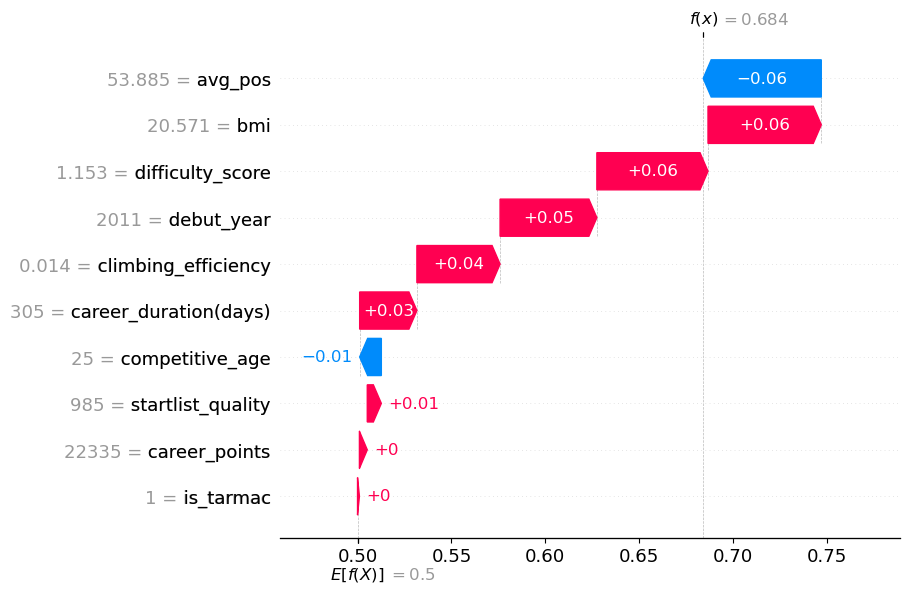

In [14]:
import shap

# Use the TreeExplainer to get SHAP values
explainer = shap.TreeExplainer(rfc)

# Calculate SHAP values
shap_values = explainer(train_data_sampled.iloc[[0]])
print(shap_values.shape)

# Visualizations
shap.plots.waterfall(shap_values[0, :, 0])


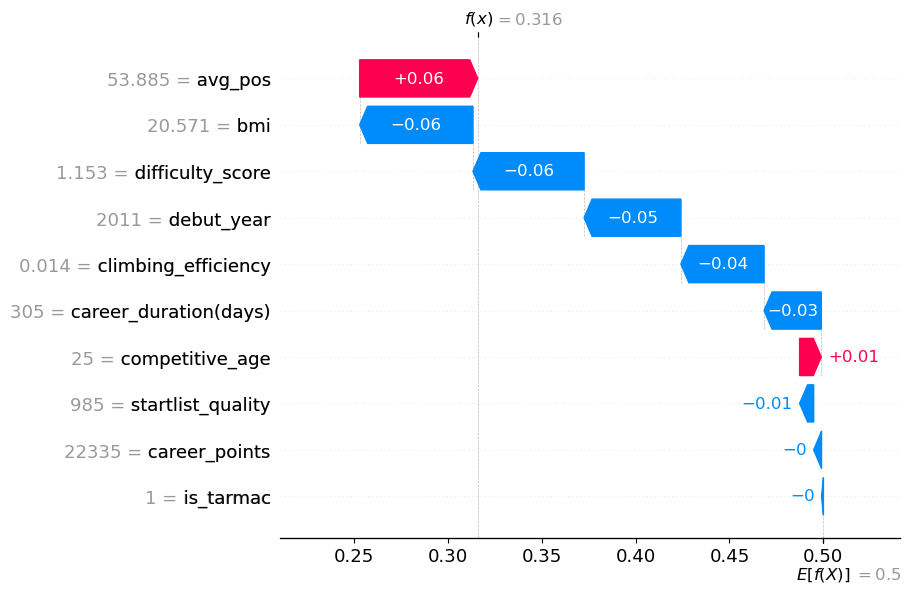

In [15]:
shap.plots.waterfall(shap_values[0, :, 1])

As you can see from the plot above has a contribution on the prediction of the model. The most important feature is the `debut_year` feature, followed by the `avg_pos` feature followed by `competitive_age` and `career_points`.

For this instance `difficulty_score` is the least important feature.

For a major understanding of the importance of each feature, we can use the `shap.summary_plot` function to plot the SHAP values of each feature.
By doing this, we can see the distribution of the SHAP values of each feature and how they contribute to the model's predictions.
We use a sampling of the data called `train_data_sample` due to the large number of samples in the dataset.

In [16]:
import shap

# Use the TreeExplainer to get SHAP values
explainer = shap.TreeExplainer(rfc)

# Calculate SHAP values
shap_values = explainer(train_data_sampled)
print(shap_values.shape)

(100, 10, 2)


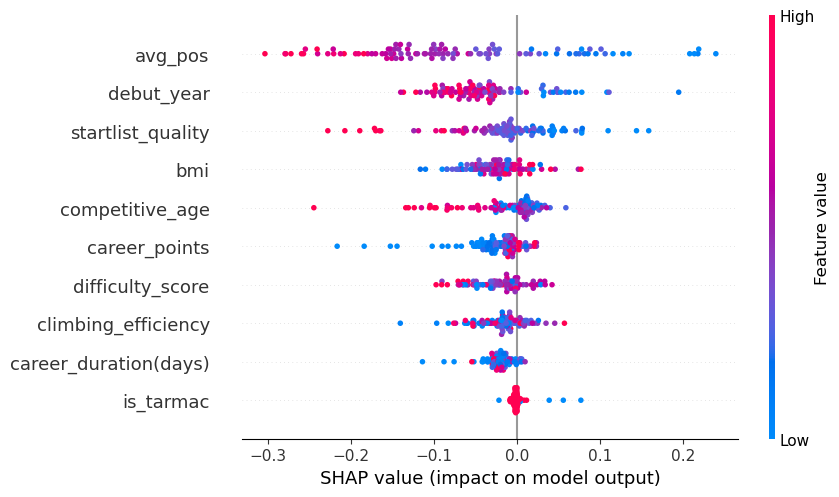

In [17]:
# Visualizations for the positive class
shap.plots.beeswarm(shap_values[..., 1])

In the plot above the features are ordered from top to bottom based on their importance. The X-axis represents the impact on model output:
- on the **right side**, the impact is positive, meaning that the feature contributes to the prediction of the model.
- on the **left side**, the impact is negative, meaning that the feature contributes to the prediction of the model.

Starting from the top, we can notice in particular that:
- `avg_pos` is the most important feature for the random forest model. The higher the `avg_pos` value, the major is the probability that the labelling is negative, this aspect was reflected during the clustering analysis. Low `avg_pos` tend to increase the probability of a positive labelling slightly.
  
- `debut_year` is the second most important feature. High `debut_year` values decrease the model's output significantly, while again low values tend to increase the probability of a positive labelling.

- `startlist_quality` is less impactful than the previous two features, but it still has a significant impact on the model's output. low `startlist_quality` values tend to increase the probability of a positive labelling, while high values tend to decrease it.

Other features like `difficulty_score` and and `career_duration` have a lower impact on the model's output, but they still contribute to the model's predictions.


## Rule explanation

In this part we concentrate on the explanation on the rule explanation of the Random Forest Model. To do so, we use the `LORE(Local Rule-based Explanations)` algorithm which uses local explanations based on rules for the prediction of the model.

In [19]:
from xailib.explainers.lore_explainer import LoreTabularExplainer

explanation_algorithm = LoreTabularExplainer(rfc)

configuration = {
    "neigh_type": "rndgen",
    "size": 200,
    "ocr":0.1,
    "ngen": 100
}

lore_train_data = pd.concat((train_data_sampled, train_labels_sampled), axis="columns")
explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)
explanation = explanation_algorithm.explain(train_data_sampled.iloc[0].values)


Now the `explanation` object contains the rules that the model uses to make predictions. We can now get the rules by running the `get_rules` method on the `explanation` object.

In [20]:
# extract the rule for the given instance
explanation.getRules()

{'premise': [{'att': 'avg_pos',
   'op': '<=',
   'thr': 54.92494010925293,
   'is_continuous': True},
  {'att': 'avg_pos',
   'op': '>',
   'thr': 33.23307800292969,
   'is_continuous': True},
  {'att': 'climbing_efficiency',
   'op': '<=',
   'thr': 0.017627605237066746,
   'is_continuous': True},
  {'att': 'bmi', 'op': '<=', 'thr': 21.425846099853516, 'is_continuous': True},
  {'att': 'difficulty_score',
   'op': '<=',
   'thr': 1.9662744998931885,
   'is_continuous': True},
  {'att': 'startlist_quality',
   'op': '>',
   'thr': 516.6485290527344,
   'is_continuous': True},
  {'att': 'debut_year',
   'op': '>',
   'thr': 1990.6287231445312,
   'is_continuous': True},
  {'att': 'competitive_age',
   'op': '>',
   'thr': 24.100300788879395,
   'is_continuous': True}],
 'cons': 0,
 'class_name': 'top_20'}

Now we can use the method `getCounterfactualRules` to get the counterfactual rules for the prediction of the model. The counterfactual rules are the rules that need to be satisfied in order to change the prediction of the model.

In [21]:
explanation.getCounterfactualRules()

[{'premise': [{'att': 'avg_pos',
    'op': '<=',
    'thr': 54.92494010925293,
    'is_continuous': True},
   {'att': 'climbing_efficiency',
    'op': '>',
    'thr': 0.017627605237066746,
    'is_continuous': True},
   {'att': 'career_points',
    'op': '>',
    'thr': 9491.31005859375,
    'is_continuous': True},
   {'att': 'bmi',
    'op': '<=',
    'thr': 22.155611991882324,
    'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '<=',
    'thr': 1278.8291015625,
    'is_continuous': True},
   {'att': 'career_duration(days)',
    'op': '>',
    'thr': 171.1548614501953,
    'is_continuous': True},
   {'att': 'competitive_age',
    'op': '>',
    'thr': 22.816740036010742,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'top_20'},
 {'premise': [{'att': 'avg_pos',
    'op': '<=',
    'thr': 54.92494010925293,
    'is_continuous': True},
   {'att': 'climbing_efficiency',
    'op': '<=',
    'thr': 0.017627605237066746,
    'is_continuous': True},
   {'att': 'bm

In [22]:
explanation.plotRules()

In [23]:
explanation.expDict["fidelity"]

0.9801248560139593

This fidelity tell us that the local model agrees with the predctions of the global model 99.7% of the synthetic neighbors used to build the local explanation.

## Counterfactual explanations

Here we provide the counterfactual explanations for the Random Forest model. Counterfactual explanations are the instances that need to be changed in order to change the prediction of the model. To do it we use the `dice_ml` library.

In [24]:
import dice_ml

# need to convert data to the Dice format
dice_train_dataset = train_data_sampled.copy()
dice_train_dataset["top_20"] = train_labels_sampled
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=rfc,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)


In [26]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[0]].drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


We print the counterfactual explanations generated by DiCE for a specific query instance.

In [27]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.571428,22335.0,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,-,-,0.0,-,-,-,1.0
1,-,-,-,-,-,-,-,-,511.0,19.1,1.0
2,22.171861,-,-,-,-,-,-,0.2501810094,-,-,1.0
3,22.595064,-,-,-,-,-,-,-,-,-,1.0
4,23.21337,-,-,-,-,-,-,-,-,-,1.0
5,-,-,-,-,-,-,-,0.3782181989,-,-,1.0
6,21.170392,-,-,-,-,-,-,-,-,13.4,1.0
7,-,-,-,-,-,-,-,0.0615625553,-,-,1.0
8,-,-,-,-,2.110454125,-,-,0.0811441335,-,-,1.0
9,-,-,-,-,-,-,-,-,-,-,1.0


In [28]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[0]].drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
    features_to_vary = ["debut_year", "avg_pos", "startlist_quality", "bmi", "is_tarmac", "difficulty_score"],
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


In [29]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,20.571428,22335.0,305.0,2011.0,1.153083,25,1,0.013842,985,53.885246,0



Diverse Counterfactual set (new outcome: 1)


,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,-,-,-,-,-,-,-,-,586.0,-,1.0
1,-,-,-,-,-,-,-,-,799.0,-,1.0
2,-,-,-,-,-,-,-,-,665.0,-,1.0
3,-,-,-,-,-,-,-,-,535.0,-,1.0
4,-,-,-,-,-,-,-,-,577.0,-,1.0
5,-,-,-,-,-,-,-,-,646.0,-,1.0
6,-,-,-,-,-,-,-,-,-,15.1,1.0
7,-,-,-,-,1.54889757,-,-,-,-,12.2,1.0
8,-,-,-,-,2.647001046,-,-,-,-,25.9,1.0
9,-,-,-,-,2.541868668,-,-,-,-,5.5,1.0


Now we generate the counterfactuals for the Random Forest model. We take the first instance from `dice_train_dataset` to generate the counterfactuals.

In [31]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.iloc[[0]].drop("top_20", axis="columns"),
    total_CFs=10, # number of counterfactuals to generate
    features_to_vary = ["debut_year", "avg_pos", "startlist_quality", "bmi", "is_tarmac", "difficulty_score"],
    stopping_threshold = 0.2
)

100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


In [22]:
counterfactuals = explanation.cf_examples_list[0].final_cfs_df
counterfactuals

,bmi,career_points,career_duration(days),debut_year,difficulty_score,competitive_age,is_tarmac,climbing_efficiency,startlist_quality,avg_pos,top_20
0,19.252757,280.0,4.0,1996.0,0.152579,27,1,0.01189,923,104.5,0
1,22.839506,280.0,4.0,1996.0,0.145415,27,1,0.01189,923,160.8,0
2,22.839506,280.0,4.0,1996.0,1.750081,27,1,0.01189,1660,104.5,0
3,22.839506,280.0,4.0,1996.0,1.412609,27,1,0.01189,1446,144.8,0
4,22.839506,280.0,4.0,2010.4,2.020431,27,1,0.01189,923,104.5,0
5,22.839506,280.0,4.0,2015.9,1.412609,27,1,0.01189,1731,104.5,0
6,22.839506,280.0,4.0,2015.1,1.412609,27,1,0.01189,1121,104.5,0
7,19.863831,280.0,4.0,1996.0,1.412609,27,1,0.01189,1971,104.5,0
8,20.839259,280.0,4.0,1997.3,1.412609,27,1,0.01189,923,104.5,0
9,22.839506,280.0,4.0,1996.0,2.143566,27,1,0.01189,923,160.0,0
